In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mos import MosDevice

In [101]:
# Step 1
# Input maximum gm/id for input transistors

ID = 0.5e-6
ID2 = 5e-6
BW = 1e3
Av = 80 # dB
CL = 200e-15
Cc = 100e-15

M2 = MosDevice()
M4 = MosDevice()
M6 = MosDevice()
M7 = MosDevice()
Mcasc = MosDevice()

# Convert Av to gain
Av = 10**(Av/20)

def sci(num):
    return "{:.2e}".format(num)

In [112]:
# Step 3
# Find possible gm/id, gmro and ft

def parallel(a, b):
    return a*b/(a+b)

def db(val):
    return np.round(20*np.log10(val), 2)

# Input
M2.gmid_val = 27
M2.id_val   = ID/2
M2.gmro_val = 4e2
M2.ft_val   = 1.55e7
M2.model    = "pch_25"
W_2         = 4e-4
L_2         = 1e-6

# Input mirror
M4.gmid_val = 20
M4.id_val   = ID/2
M4.gmro_val = 8.01e2
M4.ft_val   = 4.54e5
M2.model    = "nch_25"
W_4         = 3.15e-5
L_4         = 20e-6

# pmos output load
M6.gmid_val = 22
M6.id_val   = ID2
M6.gmro_val = 3.92e2
M6.ft_val   = 6.86e7
M2.model    = "pch_25"
W_6         = 9.23e-5
L_6         = 1e-6

# nmos output
M7.gmid_val = 24
M7.id_val   = ID2
M7.gmro_val = 2.16e2
M7.ft_val   = 4.57e7
M2.model    = "nch"
W_7         = 6e-5
L_7         = 1e-6

# Low voltage cascode current mirror transistors
Mcasc.gmid_val = 15
Mcasc.id_val   = ID/2
Mcasc.gmro_val = 4.18e1
Mcasc.ft_val   = 2.81e8
M2.model       = "nch"
W_casc         = 2.55e-7
L_casc         = 1e-6

M2.init_caps()
M4.init_caps()
M6.init_caps()
M7.init_caps()
Mcasc.init_caps()

def cascode_rout(ro1, gm2, ro2):
    return ro1 * gm2 * ro2

R1 = parallel(M2.ro(), M4.ro())
R2 = parallel(M6.ro(), M7.ro())

C1 = M2.cdb() + M4.cdb() + M7.cgs() 
C2 = M7.cdb() + M6.cdb() + CL

# Low-voltage cascode current mirror input stage
cascode = False
if cascode:
    req = cascode_rout(M2.ro(), Mcasc.gm(), Mcasc.ro())
    R1 = parallel(req, M4.ro())
    C1 = M2.cdb() + Mcasc.cdb() + M7.cgs()

a = (C2 + Cc)*R2 + (C1 + Cc)*R1 + M7.gm()*R1*R2*Cc
b = R1*R2*(C1*C2 + C1*Cc + C2*Cc)

Av = (M2.gm() * M7.gm() * R1 * R2 * (1 - (Cc/M7.gm()))) / (1 + a + b)

print("Av = {} dB".format(db(Av)))

f_p1 = 1 / (2*np.pi*(R1*(C1 + Cc*(1 + M7.gm()*R2)) + R2*(C2 + Cc)))
f_p2 = (M7.gm() * Cc) / (2*np.pi*(C1*C2 + C2*Cc + C1*Cc))
f_z1 = M7.gm() / (2*np.pi*Cc)

print("f_p1 = {} Hz".format(sci(f_p1)))
print("f_p2 = {} Hz".format(sci(f_p2)))
print("f_z1 = {} Hz".format(sci(f_z1)))

Av = 92.44 dB
f_p1 = 2.38e+02 Hz
f_p2 = 3.34e+06 Hz
f_z1 = 1.91e+08 Hz


Phase Margin: 29.13585199322094


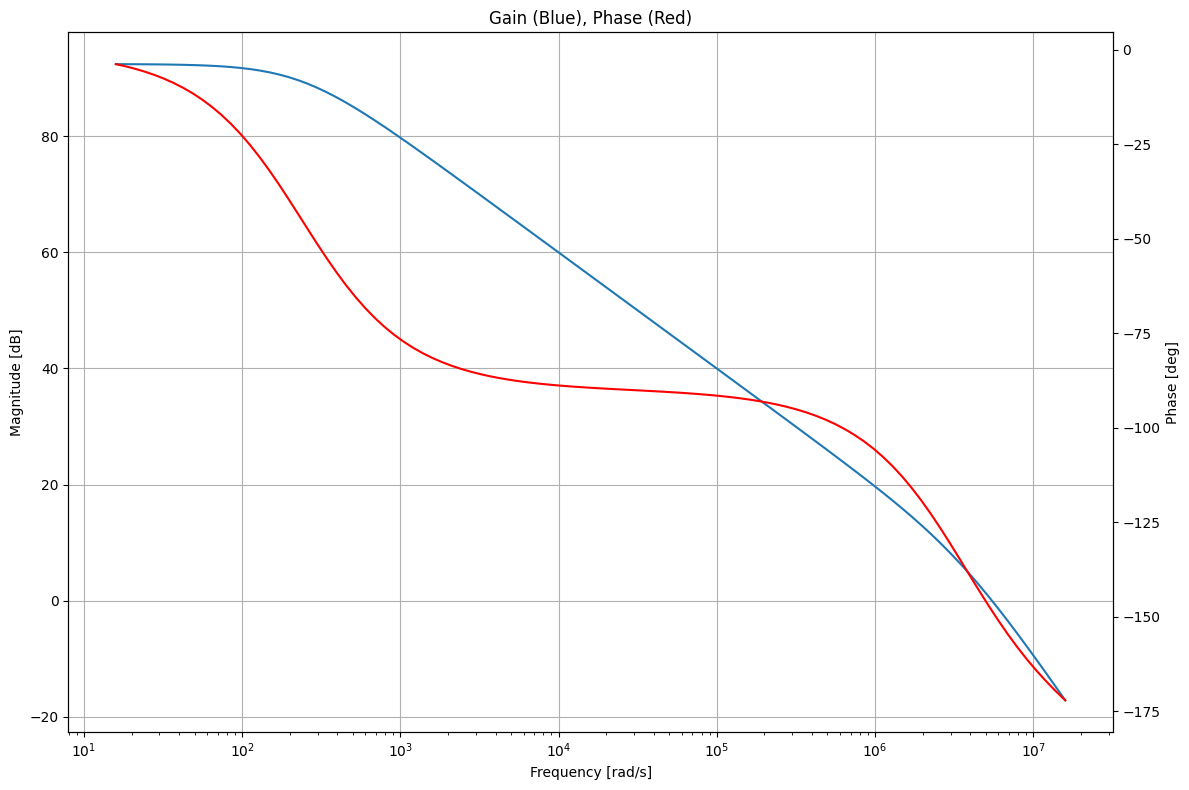

In [113]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np

sys = sp.signal.TransferFunction([-M2.gm()*R1*R2*Cc, M2.gm()*M7.gm()*R1*R2], [b, a, 1])
w, mag, phase = sp.signal.bode(sys)
w /= 2*np.pi

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

ax.set_xlabel('Frequency [rad/s]')
ax.set_ylabel('Magnitude [dB]')
ax.semilogx(w, mag)

ax2 = ax.twinx()
ax2.semilogx(w, phase, color="red")
ax2.set_ylabel('Phase [deg]')
ax.grid()

for i in range(0, len(mag)):
    if mag[i] < 0:
        print("Phase Margin: {}".format(180+phase[i]))
        break

plt.title("Gain (Blue), Phase (Red)")
fig.tight_layout()